# Water Change

## This notebook is currently under development!



### Install requirements

In [1]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

### Import required modules

In [2]:
%matplotlib inline
import datacube
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from datacube.storage import masking
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.interactive_maps import display_map
from datacube_utilities.dc_utilities import write_geotiff_from_xr

import numpy as np
import xarray as xr
import dask
from pyproj import Proj, transform

## Initialise

In [3]:
dc = datacube.Datacube(app='ls8-fcscene')

## Set up datacube query.
This includes options for crs, a groupby for overlapping datasets, a time range, and a spatial extent. 

In [4]:
#set baseline start and end of period
#baseline_start_date = '2019-1-1'
#baseline_end_date = '2019-12-30'
baseline_start_date = '2010-1-1'
baseline_end_date = '2010-12-30'

analysis_start_date = '2000-1-1'
analysis_end_date = '2000-12-30'

#resolution - have this as a variable which can be changed. 
res = (30)

# options include "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4", "SENTINEL_2"
analysis_platform = "LANDSAT_7"
baseline_platform = "LANDSAT_7"

output_projection = "EPSG:3460"
crs = "EPSG:3460"

aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.590848708679893, 177.77372360229492 -17.488875828028657, 177.62557983398438 -17.488875828028657, 177.62557983398438 -17.590848708679893))"

#this is a constant across FIJI so maybe put it not as a variable but built into query. 
#output_projection = "EPSG:32760"

## Translate inputs

In [41]:
#time_range
#format dates
from datetime import datetime
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period
baseline_time_period = createDate(baseline_start_date, baseline_end_date)
analysis_time_period = createDate(analysis_start_date, analysis_end_date)


In [42]:
#create resolution
resolution = (-res, res)

In [43]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [44]:
# format area
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [45]:
display_map(latitude = lat_extents, longitude = lon_extents)

In [46]:
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/pyproj/crs/crs.py:279: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/pyproj/crs/crs.py:279: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [47]:
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)

In [48]:
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)

In [49]:
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)

In [50]:
print(lat_extents)

(-17.590848708679893, -17.488875828028657)


In [51]:
#print(lat_range)

In [52]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        #water_product = 's2_esa_sr_granule'
        #measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        ###CHANGE WHEN S2 WOFS READY
        water_product = 'SENTINEL_2_PRODUCT DEFS'
        print('Sentinel-2 is the platform')
    elif platform in ["LANDSAT_8"]:    
        #measurements = allmeasurements + ["pixel_qa"]
        #product = 'ls8_usgs_sr_scene'
        water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        #measurements = allmeasurements + ["pixel_qa"]
        #product = 'ls7_usgs_sr_scene'
        water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        #measurements = allmeasurements + ["pixel_qa"]
        #product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        #measurements = allmeasurements + ["pixel_qa"]
        #product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return water_product

In [53]:
baseline_water_product = create_product_measurement(baseline_platform)
analysis_water_product = create_product_measurement(analysis_platform)

## Load Data 

In [54]:
#generic for load query
query = {
    'longitude': lon_range,
    'latitude': lat_range,
    'output_crs': output_projection,
    'resolution': resolution,
    'measurements': water_measurements,
    'dask_chunks': dask_chunks,
    'crs': crs
}

In [55]:
#load baseline dataset
ds_baseline = dc.load(
    platform = baseline_platform,
    product = baseline_water_product,
    time = baseline_time_period,
    **query
)
ds_baseline

,Array,Chunk
Bytes,11.53 MB,397.48 kB
Shape,"(29, 380, 523)","(1, 380, 523)"
Count,58 Tasks,29 Chunks
Type,int16,numpy.ndarray


In [56]:
#load analysis dataset
ds_analysis = dc.load(
    platform = analysis_platform,
    product = analysis_water_product,
    #measurements = measurement,
    time = analysis_time_period,
    **query
)
ds_analysis

<xarray.Dataset>
Dimensions:               (time: 11, x: 523, y: 380)
Coordinates:
  * time                  (time) datetime64[ns] 2000-02-02T10:59:42 ... 2000-11-07T11:01:33
  * y                     (y) float64 3.946e+06 3.946e+06 ... 3.934e+06
  * x                     (x) float64 1.881e+06 1.881e+06 ... 1.896e+06
Data variables:
    water_classification  (time, y, x) int16 dask.array<chunksize=(1, 380, 523), meta=np.ndarray>
Attributes:
    crs:      EPSG:3460

In [57]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

if is_dataset_empty(ds_baseline): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")
if is_dataset_empty(ds_analysis): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")


## Set no data  values to nan

In [58]:
#water_classes.isel(time = 4).water_classification.plot();
wc_baseline = dask.delayed(ds_baseline.where(ds_baseline >= 0))

In [59]:
wc_analysis = dask.delayed(ds_analysis.where(ds_analysis >= 0))

## Mask cloud

## Create mosaic of water mask

In [60]:
#create mosaic of water mask
wc_baseline_mean = wc_baseline.water_classification.mean(dim='time')

In [61]:
wc_analysis_mean = wc_analysis.water_classification.mean(dim='time')

In [62]:
print(wc_baseline_mean)

Delayed('mean-f9b94847-a4ab-489c-80e0-d9aa1d87a6b3')


In [63]:
print(wc_analysis_mean)

Delayed('mean-80cd72e2-78b3-4dd4-8ca6-5eea0d930bae')


In [64]:
###### I had to compute here as I couldn't get the next bit dasked.

In [65]:
wc_baseline_mean = wc_baseline_mean.compute()

In [66]:
wc_analysis_mean = wc_analysis_mean.compute()

In [67]:
%%time
waterpres_prob = 0.3
######THIS BIT SEEMS TO BE NOT DASKABLE?????
T0_nd_water = np.isnan(wc_baseline_mean)
wc_baseline_rc_int = wc_baseline_mean.where((wc_baseline_mean < waterpres_prob) | (T0_nd_water == True), 1) # fix > prob to water
wc_baseline_rc = wc_baseline_rc_int.where((wc_baseline_rc_int >= waterpres_prob) | (T0_nd_water == True), 0) # fix < prob to no water

CPU times: user 13.1 ms, sys: 7.16 ms, total: 20.2 ms
Wall time: 18.3 ms


In [68]:
%%time
T1_nd_water = np.isnan(wc_analysis_mean)
wc_analysis_rc_int = wc_analysis_mean.where((wc_analysis_mean < waterpres_prob) | (T1_nd_water == True), 1) # fix > prob to water
wc_analysis_rc = wc_analysis_rc_int.where((wc_analysis_rc_int >= waterpres_prob) | (T1_nd_water == True), 0) # fix < prob to no water

CPU times: user 18.7 ms, sys: 0 ns, total: 18.7 ms
Wall time: 17.1 ms


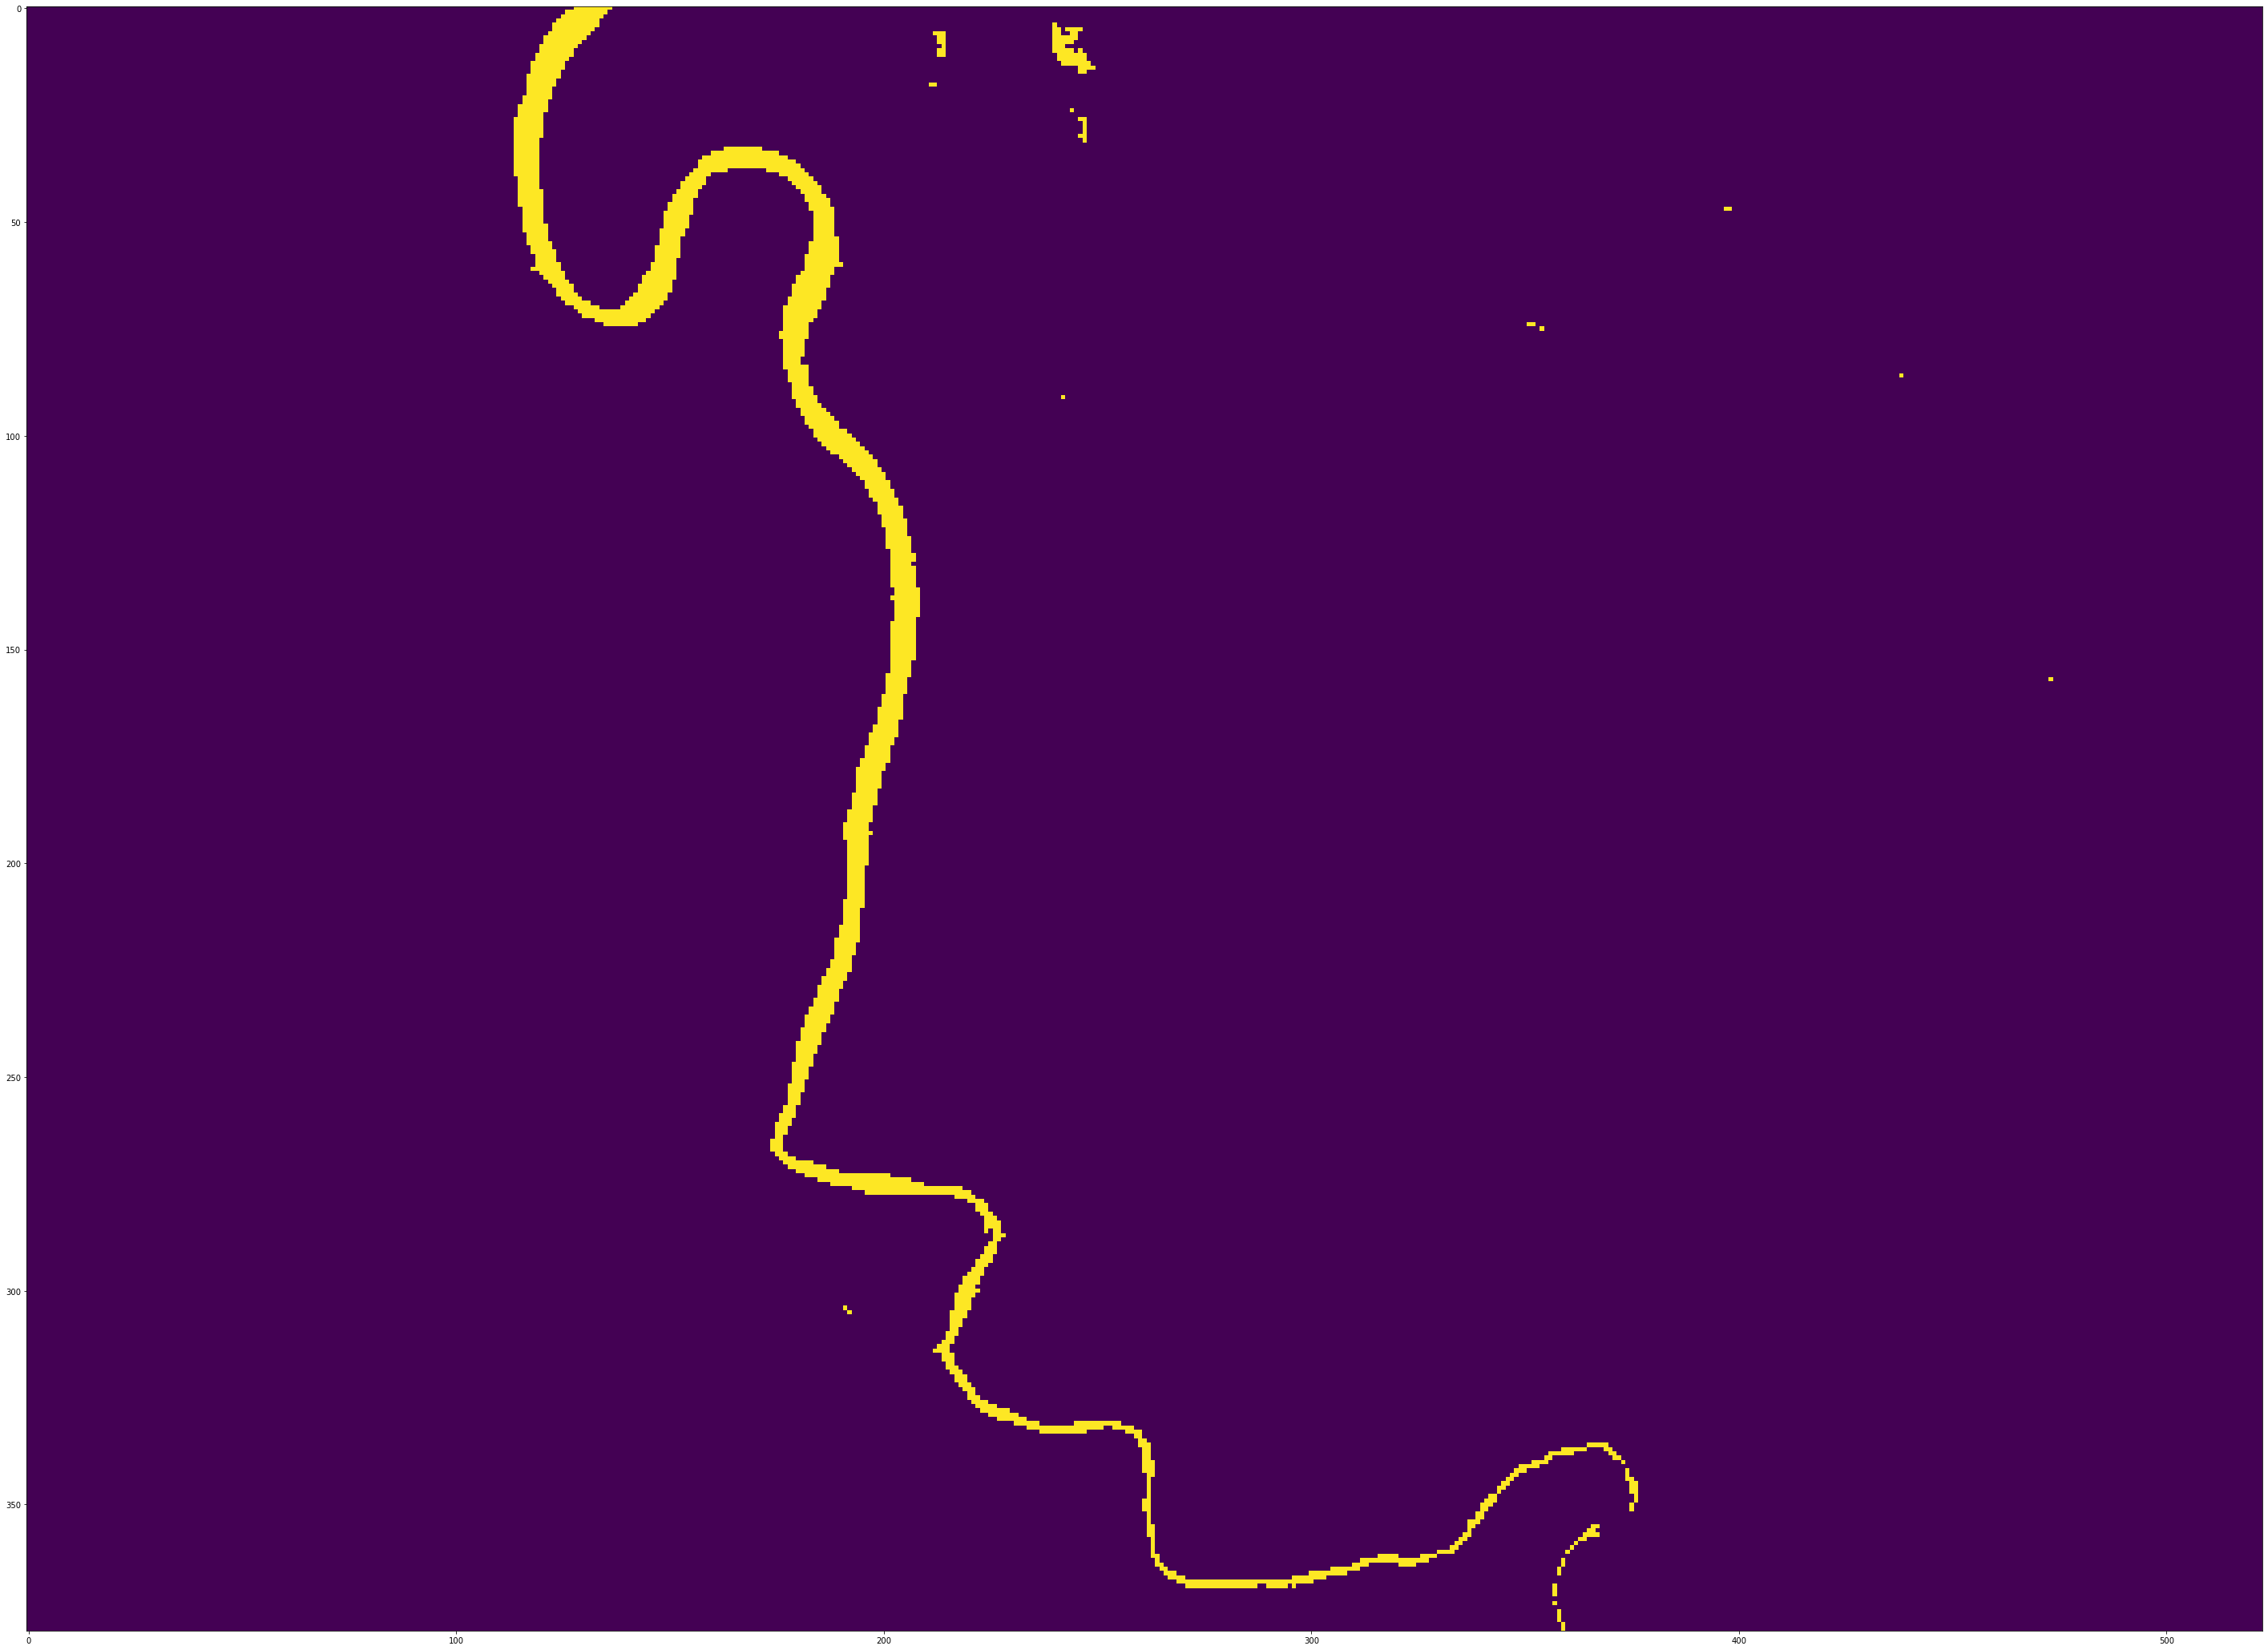

In [69]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_baseline_rc)

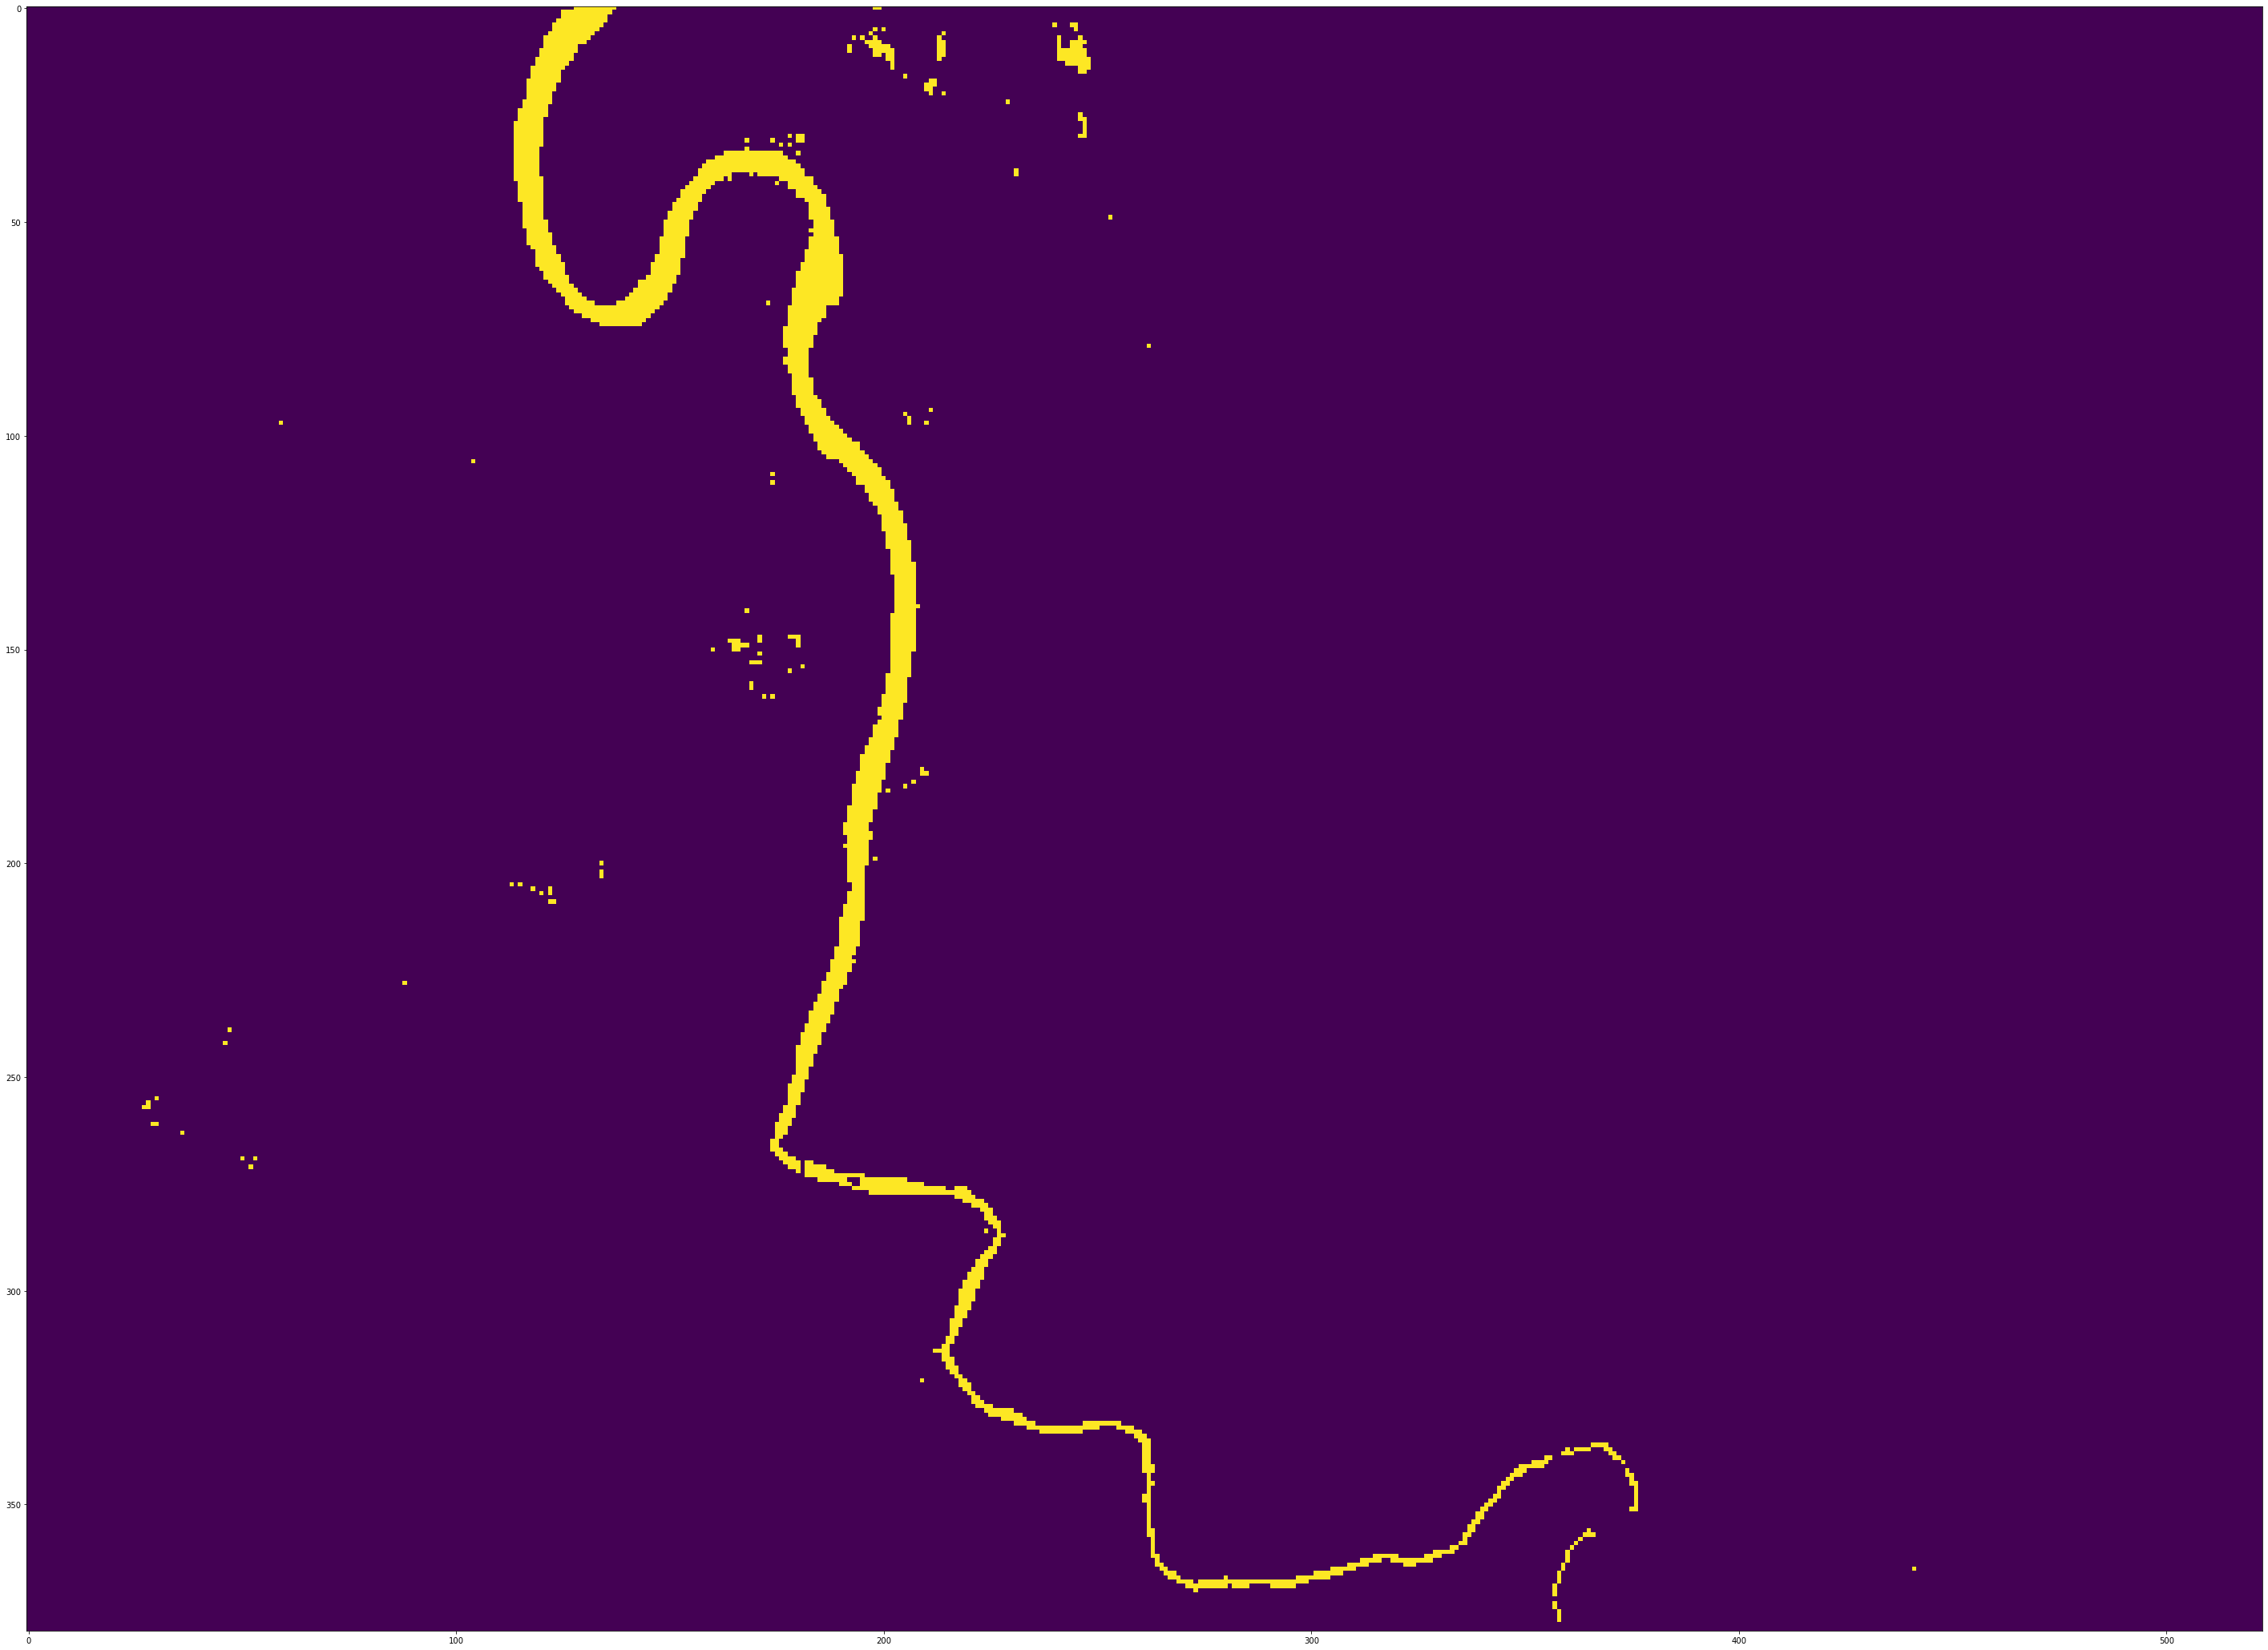

In [70]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_analysis_rc)

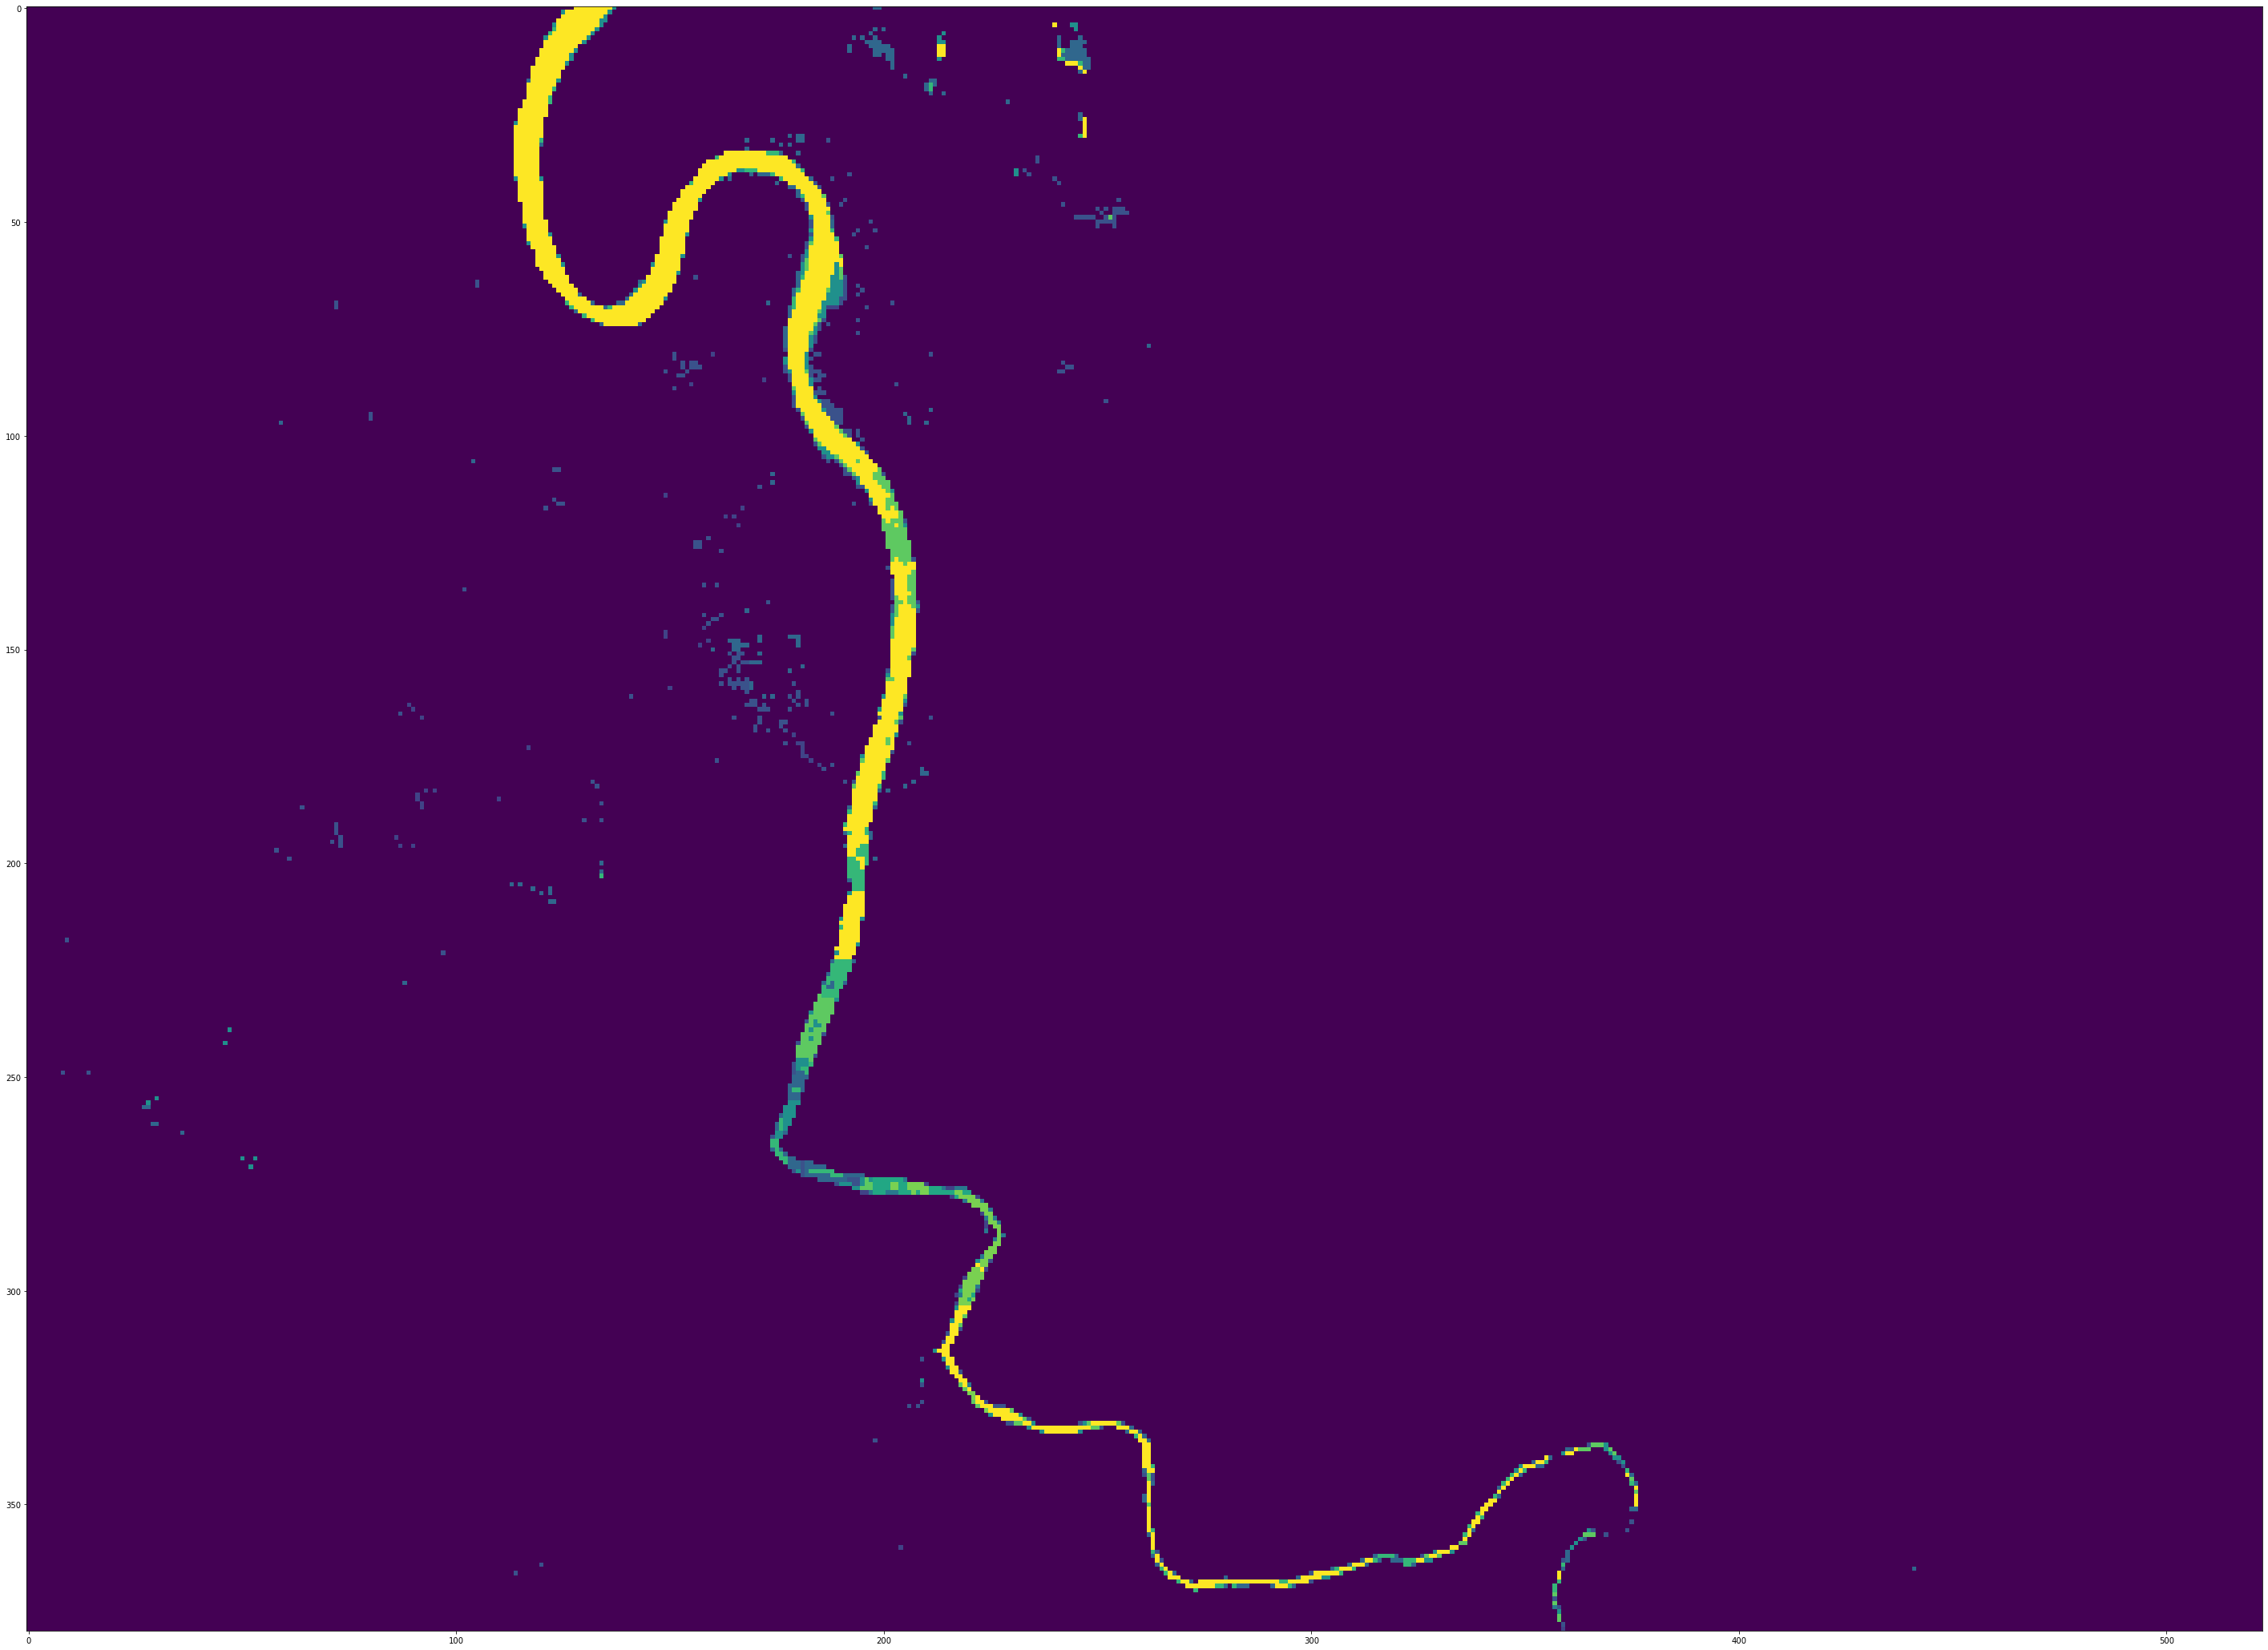

In [71]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_analysis_mean)

In [72]:
### difference is one of the outputs we want.
difference = (wc_analysis_rc - wc_baseline_rc)

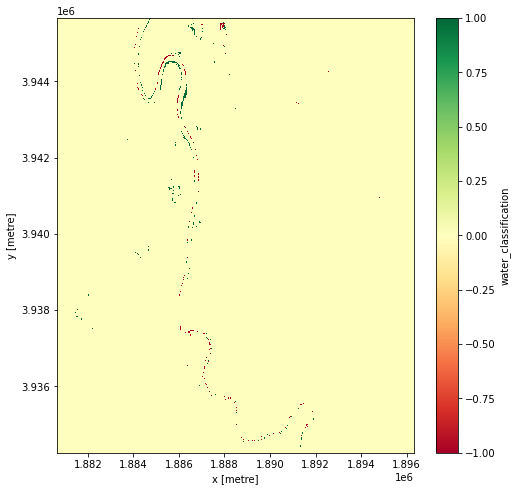

In [73]:
from matplotlib.cm import RdYlGn, Greens
plt.figure(figsize = (8,8))
difference.plot(vmin=-1, vmax=1, cmap=RdYlGn)

In [74]:
###This is the second output we want.
difference_range = (wc_analysis_mean - wc_baseline_mean)

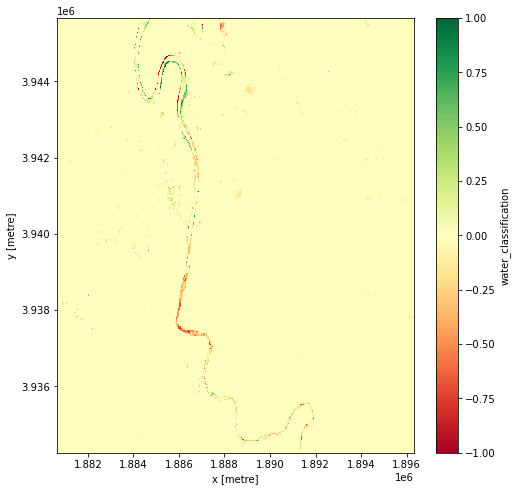

In [75]:
plt.figure(figsize = (8,8))
difference_range.plot(vmin=-1, vmax=1, cmap=RdYlGn)

In [40]:
write_geotiff_from_xr('difference_range.tiff', difference_range, crs=output_projection, x_coord = 'x', y_coord = 'y')
write_geotiff_from_xr('difference.tiff', difference, crs=output_projection, x_coord = 'x', y_coord = 'y')

---